In [112]:
import os
import numpy as np
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
import torch

#Channel auswählen
SELECTED_CHANNELS = ['accel01x', 'accel02x', 'accel03x', 'accel04x', 'accel05x', 'accel06x']
WINDOW_SIZE = 200

In [124]:
mat_path = r'D:\Bauingenieur\studienprojekt2\Daten\exemplary_datasets_dam3_010\11_Healthy\SHMTS_202106150008' #matlab 
data = loadmat(mat_path)
varname = [k for k in data if not k.startswith('__')][0]
record = data[varname][0, 0]

channel_names = [ch[0] for ch in record[3][0]]
acc_data = record[5]
fs = record[2][0, 0]

indices = [channel_names.index(ch) for ch in SELECTED_CHANNELS]
max_samples = int(fs * 60)
selected_data = acc_data[:max_samples, indices]
mean = selected_data.mean(axis=0)
std = selected_data.std(axis=0) + 1e-8
selected_data = (selected_data - mean) / std

    



In [125]:
def create_sequences(data, window_size): #Dateset
    sequences = []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        sequences.append(window)
    return np.array(sequences)

X = create_sequences(selected_data, WINDOW_SIZE)  
y = np.zeros(len(X))  

In [126]:


class SingleFileDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

dataset = SingleFileDataset(X)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [127]:
import torch.nn as nn

class Encoder(nn.Module): #编码器
    def __init__(self, input_size=6, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=6, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)  
        self.linear1 = nn.Linear(64, 16)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.linear1(x)
        return x 

In [128]:
class Decoder(nn.Module):
    def __init__(self): #解码器
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=16, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)  
        self.linear1 = nn.Linear(64, 6)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.linear1(x)
        
        return x 

In [129]:
class LSTMAutoEncoder(nn.Module): #lstm编码器解码器组合，瓶颈形状。
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") #测试cuda

Using device: cuda


In [131]:
import torch.optim as optim
import matplotlib.pyplot as plt #训练

model = LSTMAutoEncoder()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

train_losses = []

for epoch in range(50):
    model.train()
    epoch_loss = 0

    for X_batch in loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, X_batch)  
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        #epoch_loss += loss.item()
    
    train_loss = np.mean(train_losses)
    #avg_loss = epoch_loss / len(loader)
    #train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.6f}")

Epoch 1, Loss: 0.303854
Epoch 2, Loss: 0.171040
Epoch 3, Loss: 0.124440
Epoch 4, Loss: 0.100158
Epoch 5, Loss: 0.085123
Epoch 6, Loss: 0.074706
Epoch 7, Loss: 0.067029
Epoch 8, Loss: 0.061107
Epoch 9, Loss: 0.055945
Epoch 10, Loss: 0.051791
Epoch 11, Loss: 0.048259
Epoch 12, Loss: 0.045278
Epoch 13, Loss: 0.042476
Epoch 14, Loss: 0.040012
Epoch 15, Loss: 0.037854
Epoch 16, Loss: 0.035923
Epoch 17, Loss: 0.034135
Epoch 18, Loss: 0.032492
Epoch 19, Loss: 0.031038
Epoch 20, Loss: 0.029702
Epoch 21, Loss: 0.029349
Epoch 22, Loss: 0.032605
Epoch 23, Loss: 0.032328
Epoch 24, Loss: 0.031603
Epoch 25, Loss: 0.030857
Epoch 26, Loss: 0.030034
Epoch 27, Loss: 0.029174
Epoch 28, Loss: 0.028332
Epoch 29, Loss: 0.027541
Epoch 30, Loss: 0.026793
Epoch 31, Loss: 0.026091
Epoch 32, Loss: 0.025435
Epoch 33, Loss: 0.024812
Epoch 34, Loss: 0.024223
Epoch 35, Loss: 0.023671
Epoch 36, Loss: 0.023145
Epoch 37, Loss: 0.022646
Epoch 38, Loss: 0.022172
Epoch 39, Loss: 0.021721
Epoch 40, Loss: 0.021294
Epoch 41,

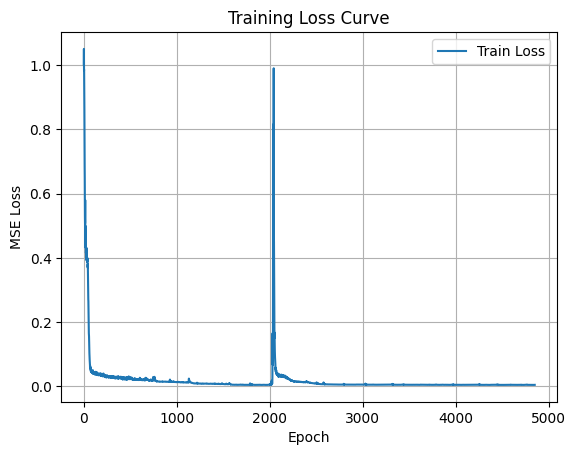

In [132]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

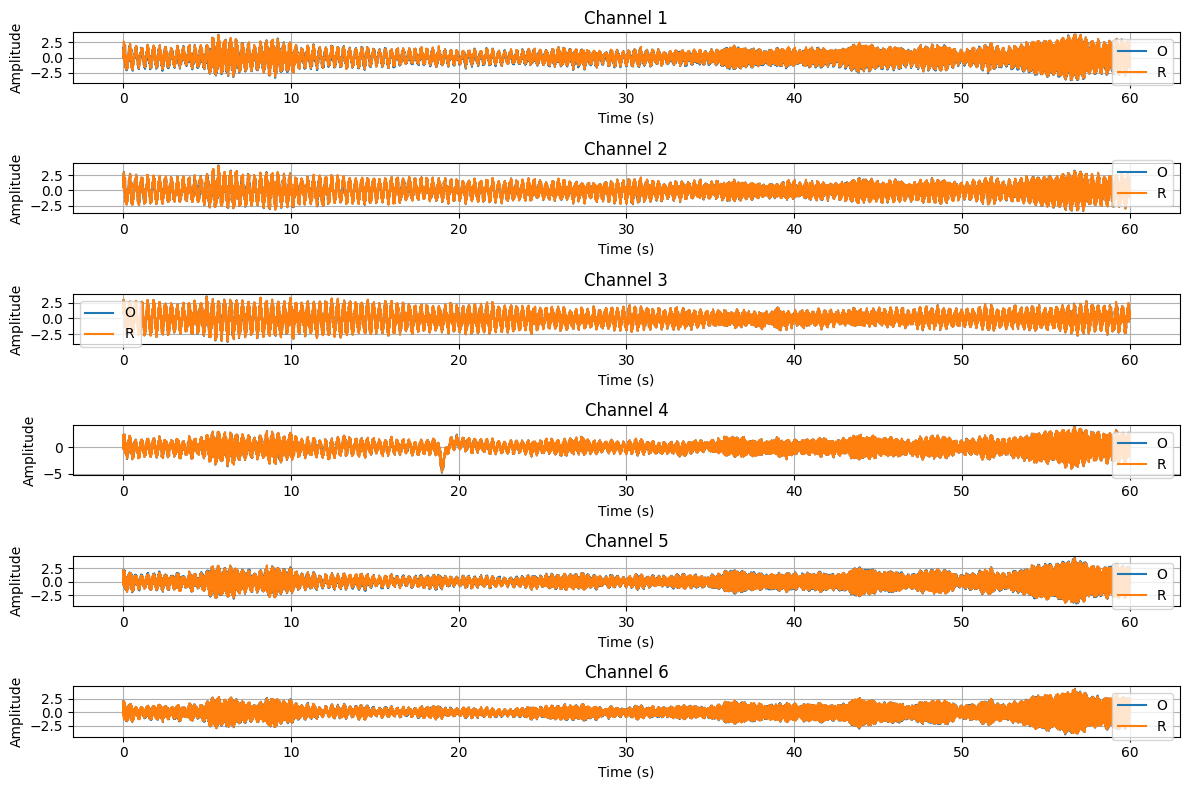

In [135]:
full_input = torch.tensor(selected_data, dtype=torch.float32).unsqueeze(0).to(device)
model.eval()
sample = dataset[0].unsqueeze(0).to(device)  
with torch.no_grad():
    reconstructed = model(full_input).cpu().squeeze(0).numpy()  
    #reconstructed = model(sample).cpu().squeeze(0).numpy()
original = selected_data  
#original = selected_data[:sample.shape[1], :]

fs = 1651.61  
time = np.arange(original.shape[0]) / fs  
#time = np.arange(sample.shape[1])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(original.shape[1]):  
    plt.subplot(original.shape[1], 1, i + 1)
    plt.plot(time, original[:, i], label='O')
    plt.plot(time, reconstructed[:, i], label='R')
    plt.title(f'Channel {i+1}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [136]:
print(reconstructed)
print(original)

[[ 1.2147502   1.4252478   0.784763   -0.22489618 -0.39260834 -0.47224665]
 [ 1.2918053   1.3584812   0.74419105 -0.27634865 -0.46319908 -0.5885296 ]
 [ 1.2833527   1.4121546   0.89916295 -0.09990089 -0.27920732 -0.41088992]
 ...
 [ 0.04424666  0.22234297 -0.04224695  0.3789626   0.41626236  0.20983565]
 [ 0.15525824  0.28410247 -0.04613569  0.12703271  0.37492955  0.27140978]
 [ 0.2530757   0.25189376 -0.0261258   0.07238147  0.1993872   0.10145316]]
[[ 1.6080521   1.1482052   0.7584746  -0.21417278 -0.3801944  -0.37478837]
 [ 1.5214546   1.2379472   0.70499235 -0.21780135 -0.56048834 -0.45117927]
 [ 1.5606012   1.2535546   0.89077276 -0.05995527 -0.32560998 -0.32704413]
 ...
 [-0.09780245  0.24883291 -0.03531433  0.35371053  0.48984778  0.15199023]
 [-0.00171469  0.32686955 -0.04657374  0.10514821  0.4435338   0.2267896 ]
 [ 0.3162053   0.22542192 -0.02405493  0.08881929  0.12264369  0.15994762]]
